In [2]:
from twitter import TwitterV2, TwitterV1
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from datetime import datetime, timezone

In [3]:
def compute_following_metric(row):
    return np.round(np.log(1+row["friends_count"]), 3)

def compute_follows_metric(row):
    return np.round(np.log(1+row["followers_count"]), 3)

def compute_tweets_metric(row):
    return np.round(np.log(1+row["statuses_count"]), 3)

def compute_tweets_per_day_metric(row):
    return np.round(np.log(1+row["average_tweets_per_day"]), 3)

In [4]:
file = open('twitter_human_bots_dataset.csv', 'rb')
original_twitter_dataframe = pd.read_csv(file, index_col=0)

twitter_dataframe = pd.DataFrame()

print(f"Dataset shape {original_twitter_dataframe.shape}")
print(f"Dataset columns: {original_twitter_dataframe.columns}")
    
try:
    # Data accessible from V2 Twitter API endpoint
    twitter_dataframe["verified"]           = original_twitter_dataframe["verified"].astype(int)
    twitter_dataframe["friends_count"]      = original_twitter_dataframe["friends_count"].astype(int)
    twitter_dataframe["followers_count"]    = original_twitter_dataframe["followers_count"].astype(int)
    twitter_dataframe["tweet_count"]        = original_twitter_dataframe["statuses_count"].astype(int)
    twitter_dataframe["account_type"]       = original_twitter_dataframe["account_type"].apply(lambda x: 1 if x == 'bot' else 0)

    # Data NOT accessible from V2 Twitter API endpoint
    twitter_dataframe["default_profile"]        = original_twitter_dataframe["default_profile"].astype(int)
    twitter_dataframe["default_profile_image"]  = original_twitter_dataframe["default_profile_image"].astype(int)
    twitter_dataframe["geo_enabled"]            = original_twitter_dataframe["geo_enabled"].astype(int)
    twitter_dataframe["average_tweets_per_day"] = original_twitter_dataframe["average_tweets_per_day"].astype(int)
    twitter_dataframe["account_age_days"]       = original_twitter_dataframe["account_age_days"].astype(int)
    twitter_dataframe["favourites_count"]       = original_twitter_dataframe["favourites_count"].astype(int)

    original_twitter_dataframe["following_metric"]          = original_twitter_dataframe.apply(compute_following_metric, axis=1)
    original_twitter_dataframe["followers_metric"]          = original_twitter_dataframe.apply(compute_follows_metric, axis=1)
    original_twitter_dataframe["tweets_metric"]             = original_twitter_dataframe.apply(compute_tweets_metric, axis=1)
    original_twitter_dataframe["tweets_per_day_metric"]     = original_twitter_dataframe.apply(compute_tweets_per_day_metric, axis=1)
except Exception as e:
    print(e)

print(twitter_dataframe)


Dataset shape (37438, 19)
Dataset columns: Index(['created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'id', 'lang', 'location', 'profile_background_image_url',
       'profile_image_url', 'screen_name', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 'account_type'],
      dtype='object')
       verified  friends_count  followers_count  tweet_count  account_type  \
0             0              4             1589        11041             1   
1             0            880              860          252             0   
2             0            594              172         1001             0   
3             0            633              517         1324             0   
4             1            116           753678         4202             0   
...         ...            ...              ...          ...           ...   
37433         0        

# Derive Distribution Graphs from input data

<Figure size 300x300 with 0 Axes>

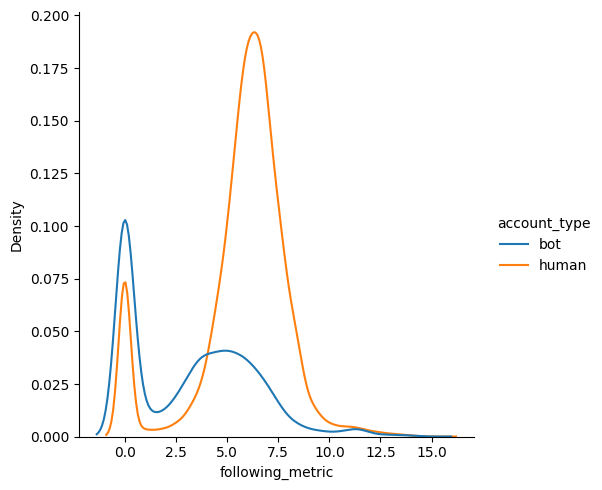

<Figure size 300x300 with 0 Axes>

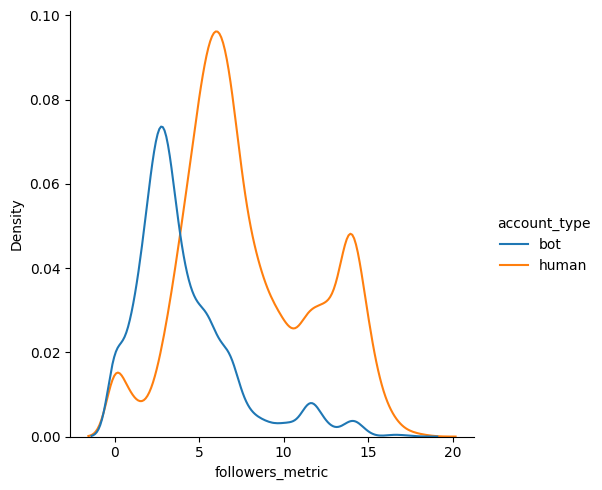

<Figure size 300x300 with 0 Axes>

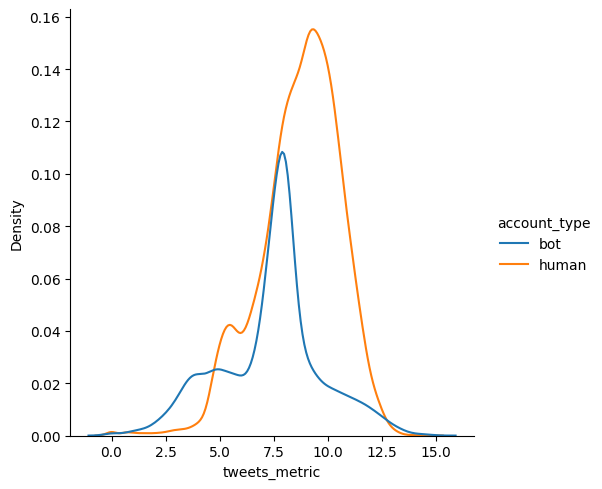

<Figure size 300x300 with 0 Axes>

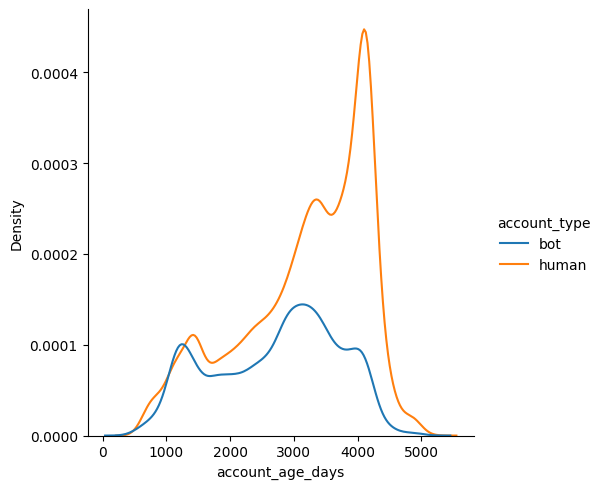

<Figure size 300x300 with 0 Axes>

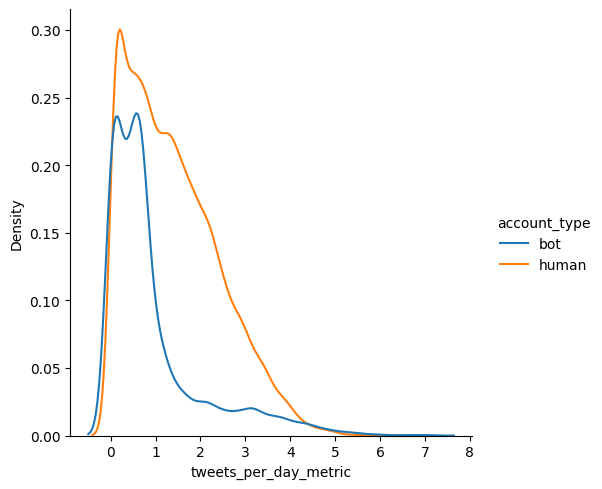

In [5]:
plt.pyplot.figure(figsize=(3, 3))
ax = sns.displot(data=original_twitter_dataframe, x="following_metric", hue="account_type", kind="kde")
plt.pyplot.title = "Account Type VS Friends Metric"

plt.pyplot.figure(figsize=(3, 3))
ax = sns.displot(data=original_twitter_dataframe, x="followers_metric", hue="account_type", kind="kde")
plt.pyplot.title = "Account Type VS Followers Metric"

plt.pyplot.figure(figsize=(3, 3))
ax = sns.displot(data=original_twitter_dataframe, x="tweets_metric", hue="account_type", kind="kde")
plt.pyplot.title = "Account Type VS Tweets Metric"

plt.pyplot.figure(figsize=(3, 3))
ax = sns.displot(data=original_twitter_dataframe, x="account_age_days", hue="account_type", kind="kde")
plt.pyplot.title = "Account Type VS Account Age"

plt.pyplot.figure(figsize=(3, 3))
ax = sns.displot(data=original_twitter_dataframe, x="tweets_per_day_metric", hue="account_type", kind="kde")
plt.pyplot.title = "Account Type VS Avg Tweets / Day"

# Feature Importance Using Logistic Regression

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

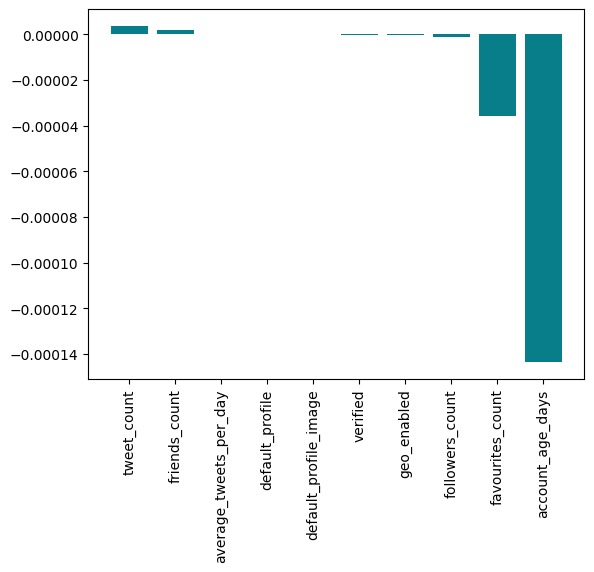

In [6]:
logreg = LogisticRegression()

X = twitter_dataframe.drop("account_type",axis=1)
y = twitter_dataframe["account_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale the data.
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

# Logistic Regression Model
logreg.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.pyplot.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.pyplot.title = 'Feature importances obtained from coefficients'
plt.pyplot.xticks(rotation=90)

# Prediction using k-Nearest Neighbors

Accuracy: 0.8180555555555555


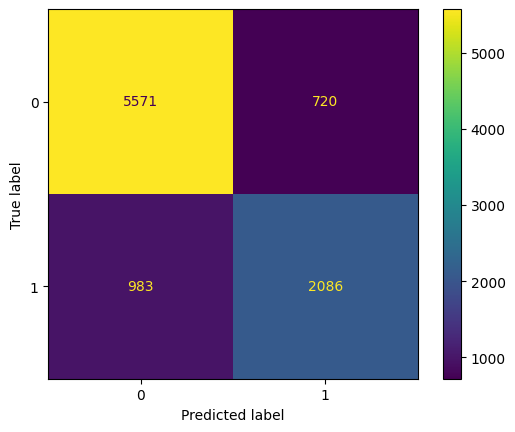

In [7]:
knn = KNeighborsClassifier(n_neighbors=10)

# K-Neighbors Classifier Model
knn.fit(train_scaled,y_train)
y_pred_knn = knn.predict(test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
c = confusion_matrix(y_test,y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=c,display_labels=knn.classes_)
disp.plot()

# Prediction using Naive Bayes Classification

Accuracy: 0.7384615384615385


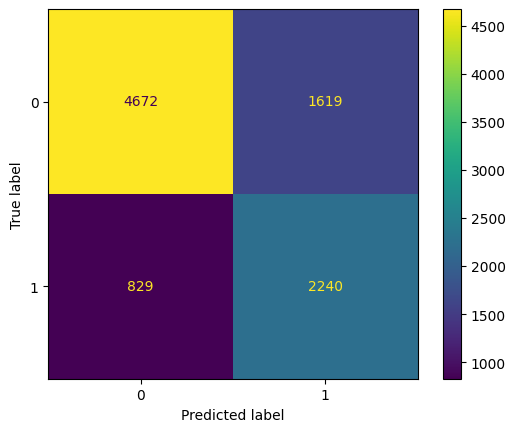

In [8]:
nbc = GaussianNB()
nbc.fit(train_scaled,y_train)
y_pred_nbc = nbc.predict(test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_nbc))
c = confusion_matrix(y_test,y_pred_nbc)
disp = ConfusionMatrixDisplay(confusion_matrix=c,display_labels=nbc.classes_)
disp.plot()

# Prediction using linear Support Vector Machine Classification

Accuracy: 0.742948717948718


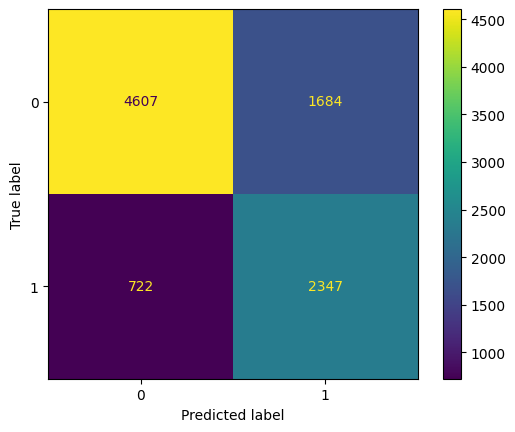

In [9]:
lsvm = SVC(kernel='linear')
lsvm.fit(train_scaled, y_train)
y_pred_lsvm = lsvm.predict(test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_lsvm))
c = confusion_matrix(y_test,y_pred_lsvm)
disp = ConfusionMatrixDisplay(confusion_matrix=c,display_labels=lsvm.classes_)
disp.plot()

# Prediction using Neural Network

Accuracy:  0.8036324786324787


c:\Users\Colton's PC\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


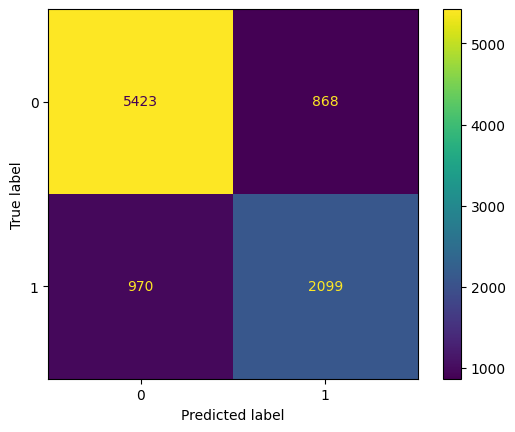

In [10]:
nn = MLPClassifier()
nn.fit(train_scaled, y_train)
y_pred_nn = nn.predict(test_scaled)
print("Accuracy: ", accuracy_score(y_test, y_pred_nn))
c = confusion_matrix(y_test,y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=c,display_labels=nn.classes_)
disp.plot()

# Prediction of user-selected Twitter accounts

In [11]:
tw = TwitterV1()

twitter_ID = ""
while(twitter_ID is not "exit"):
    twitter_ID = input("Please enter a Twitter ID: ")
    user = tw.get_account(twitter_ID)
    
    if user is None:
        print("User could not be found.")
        continue
    # Data accessible from V2 Twitter API endpoint
    features = ['verified', 'friends_count', 'followers_count', 'tweet_count', 'default_profile', 'default_profile_image', 'geo_enabled', 'average_tweets_per_day',
                    'account_age_days', 'favourites_count']
                    
    account_age_days = (datetime.now(timezone.utc) - user.created_at).days
    verified = user.verified
    geo_enabled = user.geo_enabled
    default_profile = user.default_profile
    default_profile_image = user.default_profile_image
    favourites_count = user.favourites_count
    followers_count = user.followers_count
    friends_count = user.friends_count
    statuses_count = user.statuses_count
    average_tweets_per_day = np.round(statuses_count / account_age_days, 3)

    account_features = [verified, friends_count, followers_count, statuses_count, default_profile, default_profile_image, geo_enabled, average_tweets_per_day, account_age_days, favourites_count]

    prediction_knn = knn.predict(np.matrix(account_features))
    print("k-NN Prediction: ", "Bot" if prediction_knn == 1 else "Not a bot")
    prediction_nbc = nbc.predict(np.matrix(account_features))
    print("Naive Bayes Prediction: ", "Bot" if prediction_nbc == 1 else "Not a bot")
    prediction_lsvm = lsvm.predict(np.matrix(account_features))
    print("SVM Prediction: ", "Bot" if prediction_lsvm == 1 else "Not a bot")
    prediction_NN = nn.predict(np.matrix(account_features))
    print("Neural Network Prediction: ", "Bot" if prediction_NN == 1 else "Not a bot")
    


c:\Users\Colton's PC\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
c:\Users\Colton's PC\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
c:\Users\Colton's PC\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy

k-NN Prediction:  Bot
Naive Bayes Prediction:  Bot
SVM Prediction:  Not a bot
Neural Network Prediction:  Bot
User could not be found.
